<a href="https://colab.research.google.com/github/hatemhussein/Arabic-Handwritten-Text-Identification/blob/main/VisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

**Initializing Libraries**

In [ ]:
from google.colab import drive
import os
import cv2  # For image reading
import numpy as np
from tqdm import tqdm  # For progress bar
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense, InputLayer, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import pickle

## Reading the dataset, Processing the data, Visualizing the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_folder = '/content/drive/My Drive/Dataset/isolated_words_per_user'

# Dictionary to store images and labels (image, user_id)
train_data = []  # To store tuples (image, label)
test_data = []  # To store tuples (image, label)

# Traverse each user folder
for user_folder in tqdm(sorted(os.listdir(dataset_folder))):
    user_path = os.path.join(dataset_folder, user_folder)

    # Skip if not a directory
    if not os.path.isdir(user_path):
        continue

    label = int(user_folder.replace('user', ''))  # Extract user ID

    # Dictionary to group images by words for the user
    word_to_images = {}

    # Read all images in the folder
    for image_name in os.listdir(user_path):
        image_path = os.path.join(user_path, image_name)
        # Extract the word from the filename (assuming format userXXX_word_index.png)
        word = image_name.split('_')[1]  # Extract word part (e.g., "abjadiyah" from "user001_abjadiyah_031.png")

        # Read the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            # Resize and normalize image
            image_resized = cv2.resize(image, (128, 128)).astype('float32') / 255.0

            # Group by words
            if word not in word_to_images:
                word_to_images[word] = []
            word_to_images[word].append((image_resized, label))
        else:
            print(f"Warning: Unable to read {image_path}")

    # Split words into training and testing
    words = list(word_to_images.keys())
    random.shuffle(words)
    train_words = words[:8]  # 8 words for training
    test_words = words[8:]  # 2 words for testing

    # Add images from the chosen words to train and test sets
    for word in train_words:
        train_data.extend(word_to_images[word])

    for word in test_words:
        test_data.extend(word_to_images[word])

# Convert data to numpy arrays
train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

train_images = np.array(train_images).reshape(-1, 128, 128, 1)  # Add channel dimension for grayscale
train_labels = np.array(train_labels) - 1  # Convert labels to 0-indexed
test_images = np.array(test_images).reshape(-1, 128, 128, 1)
test_labels = np.array(test_labels) - 1  # Convert labels to 0-indexed

print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Testing set: {test_images.shape}, Labels: {test_labels.shape}")

# Save numpy arrays for later use
np.save('/content/drive/My Drive/Dataset/train_images_new.npy', train_images)
np.save('/content/drive/My Drive/Dataset/train_labels_new.npy', train_labels)
np.save('/content/drive/My Drive/Dataset/test_image_new.npy', test_images)
np.save('/content/drive/My Drive/Dataset/test_labels_new.npy', test_labels)

print("Data saved successfully!")


Mounted at /content/drive


100%|██████████| 82/82 [01:47<00:00,  1.31s/it]


Training set: (3588, 128, 128, 1), Labels: (3588,)
Testing set: (890, 128, 128, 1), Labels: (890,)
Data saved successfully!


**To make surer the data is how I wan it**

In [ ]:
import pandas as pd

# Create DataFrame for training data
train_df = pd.DataFrame({
    'image_path': [f"user{label + 1:03d}.png" for _, label in train_data],
    'user_id': [label for _, label in train_data]
})

# Create DataFrame for testing data
test_df = pd.DataFrame({
    'image_path': [f"user{label + 1:03d}.png" for _, label in test_data],
    'user_id': [label for _, label in test_data]
})

# Save DataFrames to CSV
train_df.to_csv('/content/drive/My Drive/Dataset/train_set.csv', index=False)
test_df.to_csv('/content/drive/My Drive/Dataset/test_set.csv', index=False)

print("CSV files saved successfully!")


CSV files saved successfully!


## CNN

**Saving the data for quick reloading to avoid re-process everytime**

In [ ]:
# Example of loading one of them if needed
# Load saved arrays
train_images = np.load('/content/drive/My Drive/Dataset/new training-testing/train_images_new.npy')
train_labels = np.load('/content/drive/My Drive/Dataset/new training-testing/train_labels_new.npy')
test_images = np.load('/content/drive/My Drive/Dataset/new training-testing/test_image_new.npy')
test_labels = np.load('/content/drive/My Drive/Dataset/new training-testing/test_labels_new.npy')

##**Model 1**

In [ ]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(82, activation='softmax')  # 82 classes for 82 users
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
model.save('/content/drive/My Drive/Dataset/cnn_model1.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.0159 - loss: 4.3914 - val_accuracy: 0.0000e+00 - val_loss: 8.5200
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1141 - loss: 3.7085 - val_accuracy: 0.0000e+00 - val_loss: 12.4984
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2860 - loss: 2.8311 - val_accuracy: 0.0000e+00 - val_loss: 19.4599
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4708 - loss: 1.9980 - val_accuracy: 0.0000e+00 - val_loss: 23.6872
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6696 - loss: 1.2233 - val_accuracy: 0.0000e+00 - val_loss: 23.1395
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8378 - loss: 0.6637 - val_accuracy: 0.0000e+00 - val_loss: 32.7932
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9338 - loss: 0.2995 - val_accuracy: 7.6570e-04 - val_loss: 36.1427
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accurac

##**Model 2**

In [ ]:
# CNN Model
model2 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Flattening and Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(82, activation='softmax')  # 82 classes for users
])

# Compile the model
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
# model2.summary()

# Train the model
history2 = model2.fit(train_images, train_labels,
                     epochs=13,
                     batch_size=32,
                     validation_split=0.2)  # 20% of training data for validation

model2.save('/content/drive/My Drive/Dataset/cnn_model2.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.1310 - loss: 4.0755 - val_accuracy: 0.0000e+00 - val_loss: 70.1944
Epoch 2/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.4304 - loss: 2.1675 - val_accuracy: 0.0000e+00 - val_loss: 61.2409
Epoch 3/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7151 - loss: 1.0594 - val_accuracy: 0.0000e+00 - val_loss: 88.4611
Epoch 4/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8993 - loss: 0.4558 - val_accuracy: 0.0000e+00 - val_loss: 702.2279
Epoch 5/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9772 - loss: 0.1610 - val_accuracy: 0.0000e+00 - val_loss: 11.5424
Epoch 6/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9941 - loss: 0.0670 - val_accuracy: 0.0000e+00 - val_loss: 23.4071
Epoch 7/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9957 - loss: 0.0394 - val_accuracy: 0.0000e+00 - val_loss: 25.0534
Epoch 8/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - ac

**Testing the two models with the testing dataset**

In [ ]:
# Evaluate model1
loss1, accuracy1 = model.evaluate(test_images, test_labels, verbose=1)
print(f"Model1 Test Loss: {loss1:.4f}, Test Accuracy: {accuracy1:.4f}")

# Evaluate model2
loss2, accuracy2 = model2.evaluate(test_images, test_labels, verbose=1)
print(f"Model2 Test Loss: {loss2:.4f}, Test Accuracy: {accuracy2:.4f}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1262 - loss: 9.3217
Model1 Test Loss: 16.9434, Test Accuracy: 0.0979
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.0150 - loss: 776.8152
Model2 Test Loss: 966.8745, Test Accuracy: 0.0130


**Seeing what the two models predict**

In [ ]:
# Get predictions from model1
predictions1 = model.predict(test_images)

# Convert predictions (probabilities) to class labels
predicted_labels1 = np.argmax(predictions1, axis=1)

# Get predictions from model2
predictions2 = model2.predict(test_images)
predicted_labels2 = np.argmax(predictions2, axis=1)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


**Predictions**

Model1 Predictions:


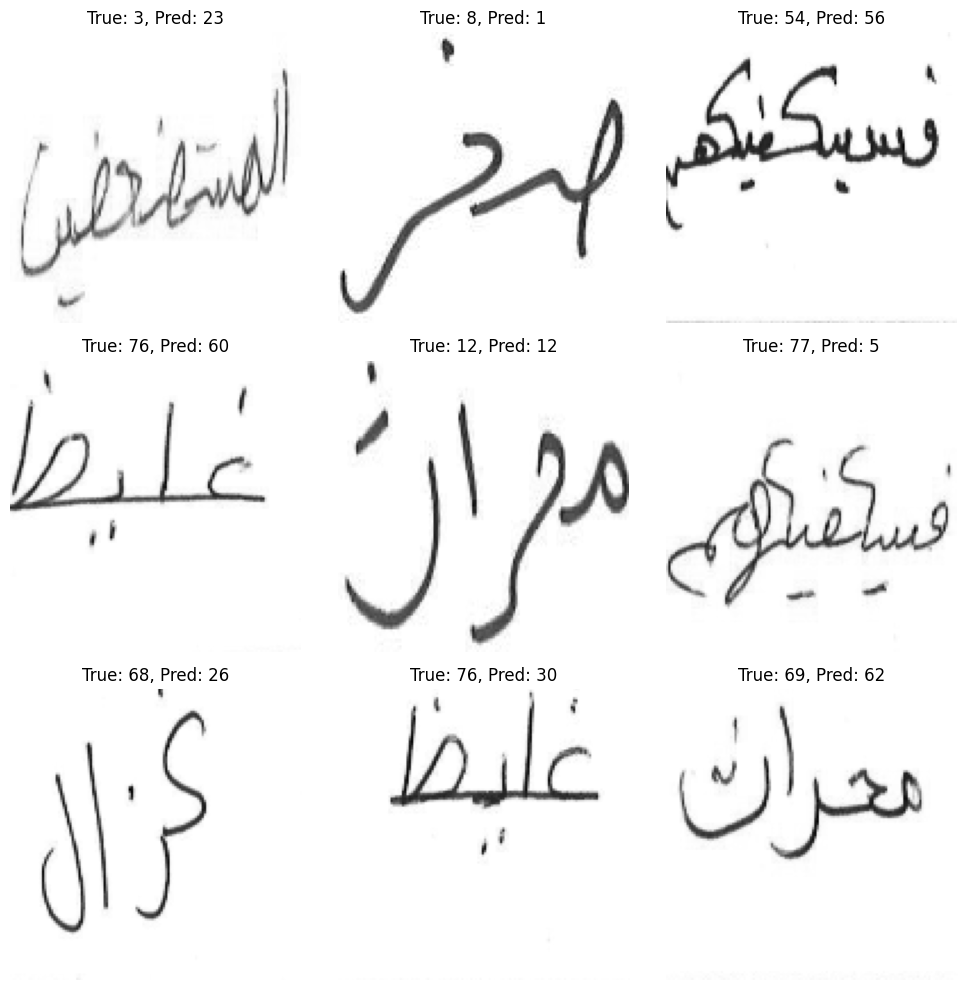

Model2 Predictions:


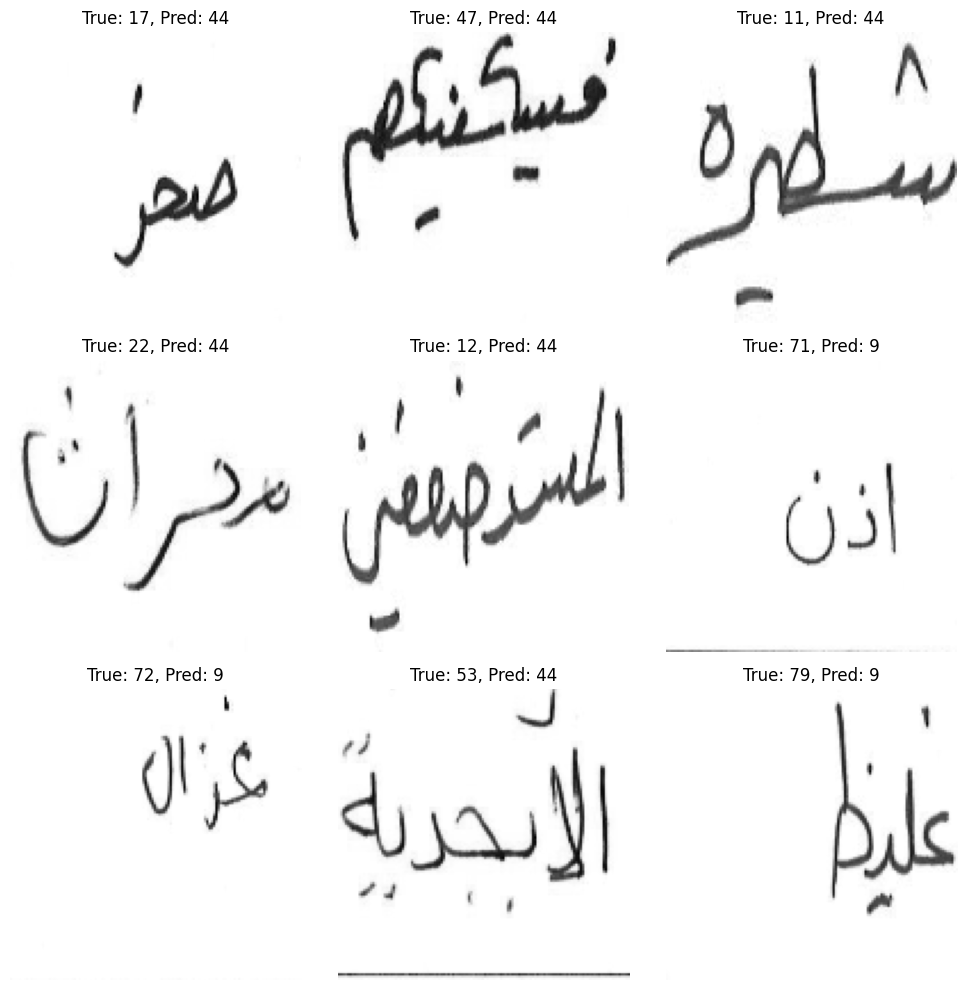

In [ ]:
def plot_predictions(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(10, 10))
    random_indices = random.sample(range(len(images)), num_images)

    for i, idx in enumerate(random_indices):
        image = images[idx].reshape(128, 128)
        true_label = true_labels[idx] + 1  # Convert back to original label range (1 to 82)
        predicted_label = predicted_labels[idx] + 1

        plt.subplot(3, 3, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot predictions for model1
print("Model1 Predictions:")
plot_predictions(test_images, test_labels, predicted_labels1)

# Plot predictions for model2
print("Model2 Predictions:")
plot_predictions(test_images, test_labels, predicted_labels2)


##**Model 3**

In [ ]:
model3 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(82, activation='softmax')  # 82 classes for users
])

# Compile Model
learning_rate = 0.001  # Initial learning rate
optimizer = Adam(learning_rate=learning_rate)
model3.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Learning Rate Scheduler (reduce LR if no improvement for 3 epochs)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train Model
history3 = model3.fit(train_images, train_labels,
                      epochs=20,
                      batch_size=32,
                      validation_data=(test_images, test_labels),
                      callbacks=[lr_scheduler])

model3.save('/content/drive/My Drive/Dataset/cnn_model3.keras')

Epoch 1/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.0789 - loss: 4.4560 - val_accuracy: 0.0124 - val_loss: 26.3881 - learning_rate: 0.0010
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.3618 - loss: 2.5113 - val_accuracy: 0.0130 - val_loss: 13.1752 - learning_rate: 0.0010
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5275 - loss: 1.8487 - val_accuracy: 0.0093 - val_loss: 83.1181 - learning_rate: 0.0010
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8196 - loss: 0.8246 - val_accuracy: 0.0112 - val_loss: 37.9836 - learning_rate: 0.0010
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9205 - loss: 0.4364 - val_accuracy: 0.0415 - val_loss: 11.5756 - learning_rate: 0.0010
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8814 - loss: 0.5255 - val_accuracy: 0.1766 - val_loss: 3.8447 - learning_rate: 0.0010
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9720 - l

**Monitoring training performace**

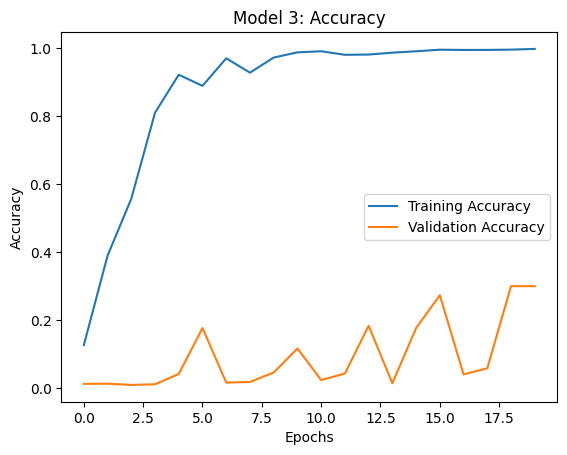

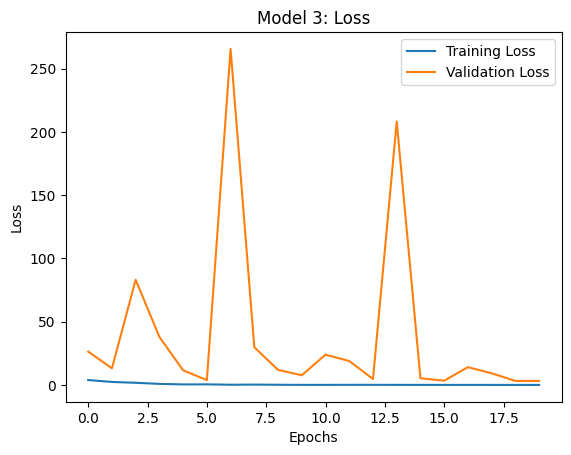

In [ ]:
# Plot training and validation accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 3: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model 3: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate Model 3 on the Test Set
loss3, accuracy3 = model3.evaluate(test_images, test_labels, verbose=1)
print(f"Model 3 Test Loss: {loss3:.4f}, Test Accuracy: {accuracy3:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2669 - loss: 3.4451
Model 3 Test Loss: 3.1981, Test Accuracy: 0.2999


## **Model 4**

In [ ]:
model4 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(82, activation='softmax')
])

# Compile Model with SGD optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)  # SGD with momentum
model4.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the Model
history4 = model4.fit(train_images, train_labels,
                      epochs=50,  # Train for longer epochs
                      batch_size=32,
                      validation_data=(test_images, test_labels),
                      callbacks=[lr_scheduler])

model4.save('/content/drive/My Drive/Dataset/cnn_model4.keras')


Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.0894 - loss: 4.6243 - val_accuracy: 0.0149 - val_loss: 16.7133 - learning_rate: 0.0100
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.2502 - loss: 3.0094 - val_accuracy: 0.0130 - val_loss: 66.2571 - learning_rate: 0.0100
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.3710 - loss: 2.4051 - val_accuracy: 0.0124 - val_loss: 25.8751 - learning_rate: 0.0100
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5008 - loss: 1.7701 - val_accuracy: 0.0223 - val_loss: 250.1769 - learning_rate: 0.0100
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6639 - loss: 1.1648 - val_accuracy: 0.0211 - val_loss: 368.9529 - learning_rate: 0.0100
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6483 - loss: 1.2374 - val_accuracy: 0.0155 - val_loss: 16.3274 - learning_rate: 0.0100
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.820

**Check Performance**

In [ ]:
loss4, accuracy4 = model4.evaluate(test_images, test_labels, verbose=1)
print(f"Model 4 Test Loss: {loss4:.4f}, Test Accuracy: {accuracy4:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2594 - loss: 4.1599
Model 4 Test Loss: 3.8882, Test Accuracy: 0.2677


**Visualize Training Progress**

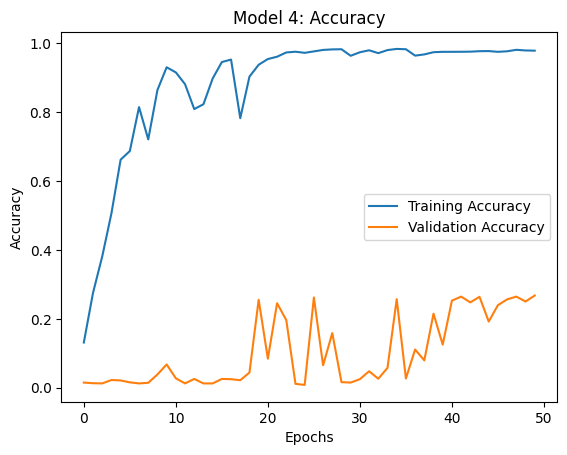

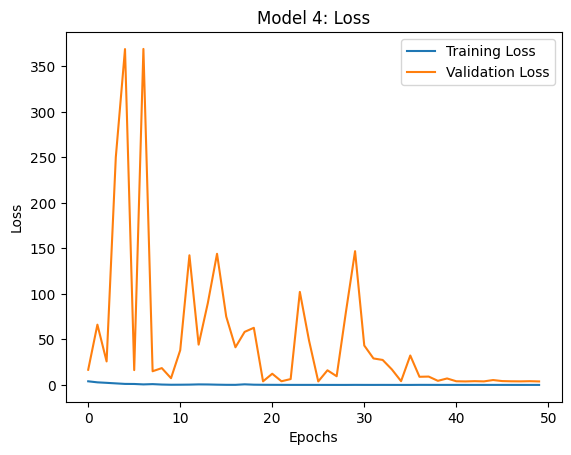

In [ ]:
# Plot training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 4: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Model 4: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Analyze the predictions**

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Model4 Predictions:


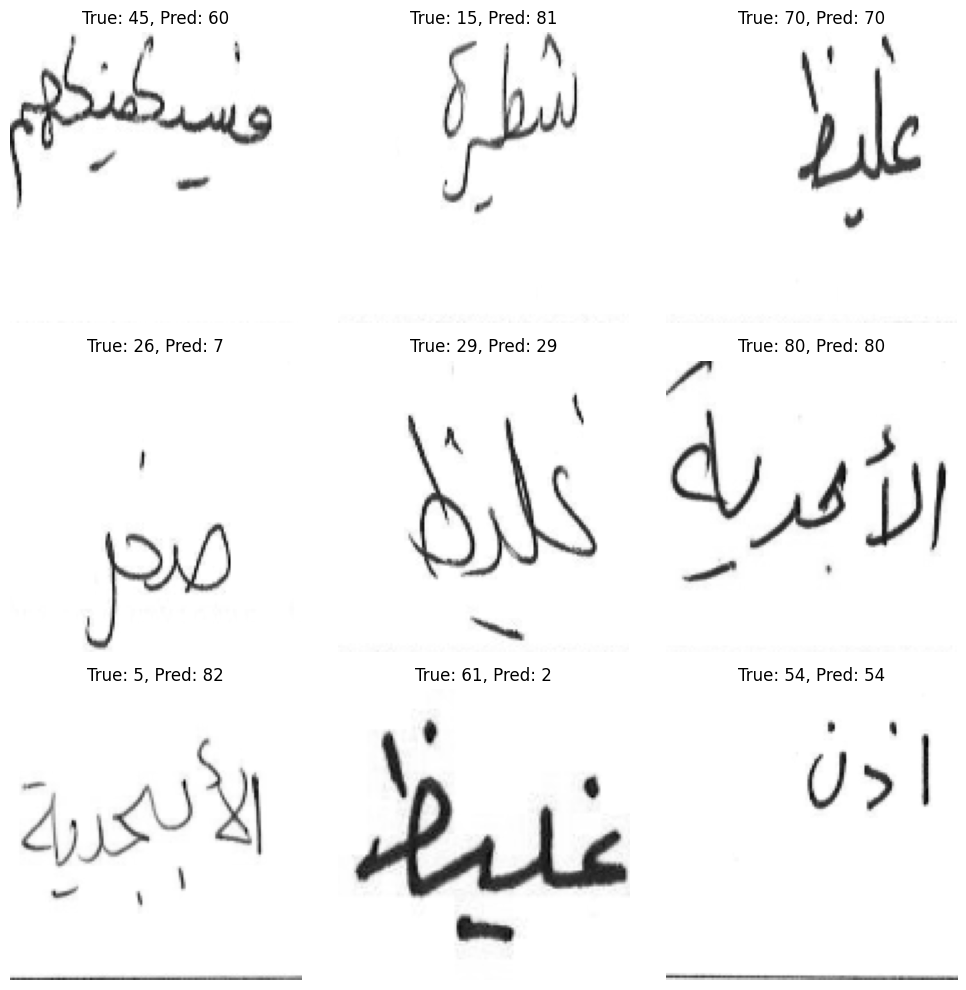

In [ ]:
# Get predictions from model4
predictions4 = model4.predict(test_images)
predicted_labels4 = np.argmax(predictions4, axis=1)

# Plot predictions for model4
print("Model4 Predictions:")
plot_predictions(test_images, test_labels, predicted_labels4)

## **Model 5**

In [ ]:
model5 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(82, activation='softmax')
])

# Compile Model with SGD optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)  # SGD with momentum
model5.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Class Balancing
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Train the Model
history5 = model5.fit(train_images, train_labels,
                      epochs=50,  # Train for longer epochs
                      batch_size=32,
                      validation_data=(test_images, test_labels),
                      class_weight=class_weights,
                      callbacks=[lr_scheduler])

model5.save('/content/drive/My Drive/Dataset/cnn_model5.keras')


Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.0817 - loss: 4.4938 - val_accuracy: 0.0124 - val_loss: 22.5068 - learning_rate: 0.0100
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - accuracy: 0.2141 - loss: 3.1612 - val_accuracy: 0.0136 - val_loss: 19.3482 - learning_rate: 0.0100
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.2949 - loss: 2.6932 - val_accuracy: 0.0124 - val_loss: 66.6220 - learning_rate: 0.0100
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.3912 - loss: 2.1831 - val_accuracy: 0.0372 - val_loss: 30.1655 - learning_rate: 0.0100
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5172 - loss: 1.6904 - val_accuracy: 0.0366 - val_loss: 31.2471 - learning_rate: 0.0100
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6037 - loss: 1.3254 - val_accuracy: 0.0112 - val_loss: 30.9506 - learning_rate: 0.0100
Epoch 7/50
204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.667

In [ ]:
loss5, accuracy5 = model5.evaluate(test_images, test_labels, verbose=1)
print(f"Model 5 Test Loss: {loss5:.4f}, Test Accuracy: {accuracy5:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2733 - loss: 3.3823
Model 5 Test Loss: 3.0059, Test Accuracy: 0.3141


## **Model 6**

In [ ]:
model6 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fourth
    Conv2D(265, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(82, activation='softmax')
])

# Compile Model with SGD optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.5)  # SGD with momentum
model6.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Class Balancing
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Train the Model
history6 = model6.fit(train_images, train_labels,
                      epochs=100,
                      batch_size=64,
                      validation_data=(test_images, test_labels),
                      class_weight=class_weights,
                      callbacks=[lr_scheduler])

loss6, accuracy6 = model6.evaluate(test_images, test_labels, verbose=1)
print(f"Model 6 Test Loss: {loss6:.4f}, Test Accuracy: {accuracy6:.4f}")
model6.save('/content/drive/My Drive/Dataset/cnn_model6.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.0318 - loss: 5.4661 - val_accuracy: 0.0124 - val_loss: 6.0042 - learning_rate: 0.0100
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.0696 - loss: 4.4983 - val_accuracy: 0.0124 - val_loss: 7.9753 - learning_rate: 0.0100
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.0980 - loss: 4.1405 - val_accuracy: 0.0124 - val_loss: 10.1662 - learning_rate: 0.0100
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1471 - loss: 3.7180 - val_accuracy: 0.0143 - val_loss: 7.8937 - learning_rate: 0.0100
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2006 - loss: 3.3372 - val_accuracy: 0.0173 - val_loss: 7.7202 - learning_rate: 0.0100
Epoch 6/100
101/103 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2021 - loss: 3.2737
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2025 - l

## **Model 7**

In [ ]:
model7 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),

    # Second Convolutional Block
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.4),

    # Fourth
    Conv2D(265, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.4),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    # Output Layer
    Dense(82, activation='softmax', kernel_regularizer=l2(0.001))
])

# Compile Model with SGD optimizer
optimizer = Adam(learning_rate=0.001)
model7.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Class Balancing
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Train the Model
history7 = model7.fit(train_images, train_labels,
                      epochs=100,  # Train for longer epochs
                      batch_size=64,
                      validation_data=(test_images, test_labels),
                      class_weight=class_weights,
                      callbacks=[lr_scheduler])

loss7, accuracy7 = model7.evaluate(test_images, test_labels, verbose=1)
print(f"Model 7 Test Loss: {loss7:.4f}, Test Accuracy: {accuracy7:.4f}")
model7.save('/content/drive/My Drive/Dataset/cnn_model7.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.0277 - loss: 5.8341 - val_accuracy: 0.0124 - val_loss: 6.5082 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.0870 - loss: 4.7725 - val_accuracy: 0.0124 - val_loss: 8.0308 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1440 - loss: 4.2503 - val_accuracy: 0.0136 - val_loss: 8.3545 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1686 - loss: 4.0728 - val_accuracy: 0.0124 - val_loss: 7.7549 - learning_rate: 0.0010
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2174 - loss: 3.7482 - val_accuracy: 0.0204 - val_loss: 17.4669 - learning_rate: 0.0010
Epoch 6/100
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2812 - loss: 3.4755
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2814 - 

## **Model 8 (Best one)**

In [ ]:
# Same as model 7 but:
# Dropout(0.3)  # Instead of 0.4 or 0.5
# Fourth conv2d became 512
# Conv2D(64, (3, 3), kernel_regularizer=l2(0.0005))  # Instead of 0.001

model8 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),

    # Second Convolutional Block
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),

    # Fourth
    Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    # Output Layer
    Dense(82, activation='softmax', kernel_regularizer=l2(0.005))
])

# Compile Model with SGD optimizer
optimizer = Adam(learning_rate=0.001)
model8.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Class Balancing
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Train the Model
history8 = model8.fit(train_images, train_labels,
                      epochs=100,
                      batch_size=64,
                      validation_data=(test_images, test_labels),
                      class_weight=class_weights,
                      callbacks=[lr_scheduler])

loss8, accuracy8 = model8.evaluate(test_images, test_labels, verbose=1)
print(f"Model 8 Test Loss: {loss8:.4f}, Test Accuracy: {accuracy8:.4f}")
model8.save('/content/drive/My Drive/Dataset/cnn_model8.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.0464 - loss: 10.2862 - val_accuracy: 0.0124 - val_loss: 10.6230 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1684 - loss: 7.2127 - val_accuracy: 0.0124 - val_loss: 11.8977 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2569 - loss: 5.7879 - val_accuracy: 0.0124 - val_loss: 12.4696 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3731 - loss: 4.7178 - val_accuracy: 0.0124 - val_loss: 14.5878 - learning_rate: 0.0010
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4781 - loss: 3.9695 - val_accuracy: 0.0130 - val_loss: 14.9127 - learning_rate: 0.0010
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4778 - loss: 3.7988
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.47

### visualizing predictions For Model 7

In [ ]:
# Get predictions from model7
predictions7 = model7.predict(test_images)

# Convert predictions (probabilities) to class labels
predicted_labels7 = np.argmax(predictions7, axis=1)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Model7 Predictions:


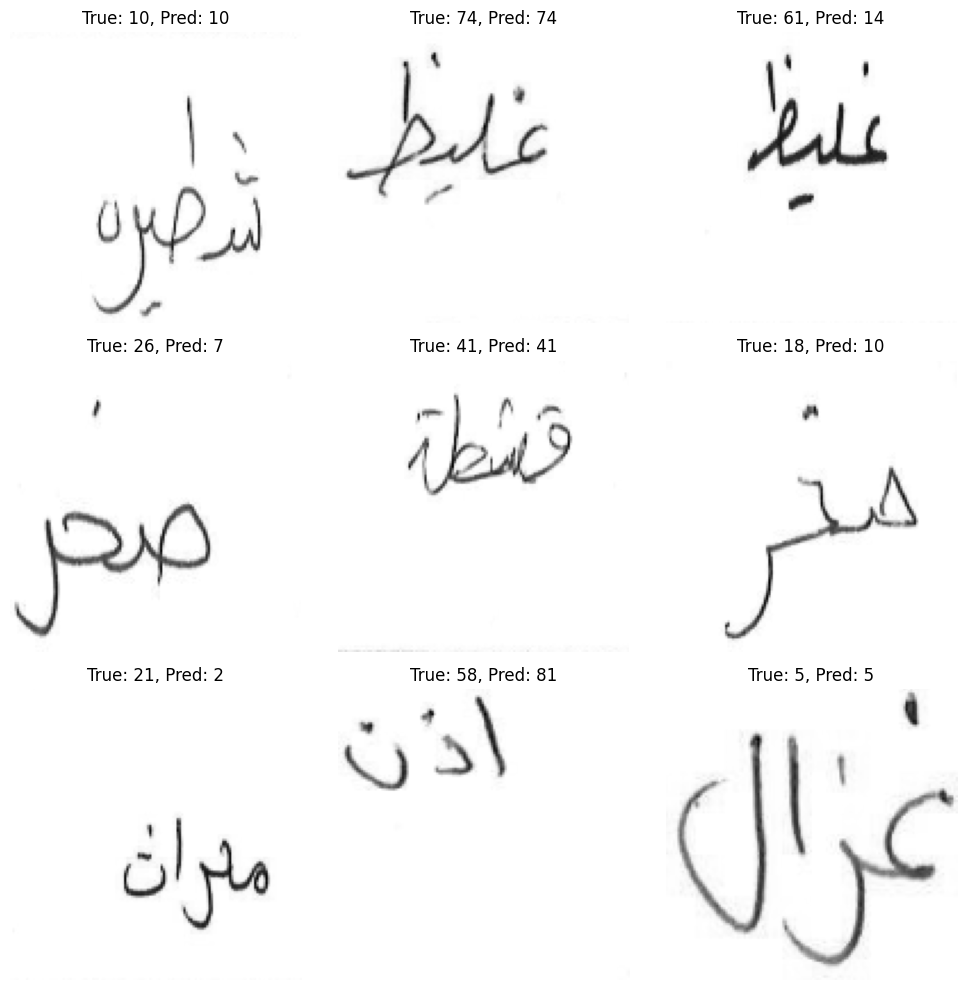

In [ ]:
def plot_predictions(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(10, 10))
    random_indices = random.sample(range(len(images)), num_images)

    for i, idx in enumerate(random_indices):
        image = images[idx].reshape(128, 128)
        true_label = true_labels[idx] + 1  # Convert back to original label range (1 to 82)
        predicted_label = predicted_labels[idx] + 1

        plt.subplot(3, 3, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot predictions for model7
print("Model7 Predictions:")
plot_predictions(test_images, test_labels, predicted_labels7)


### Observing Predictions For Model 8

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Model 8 Predictions:


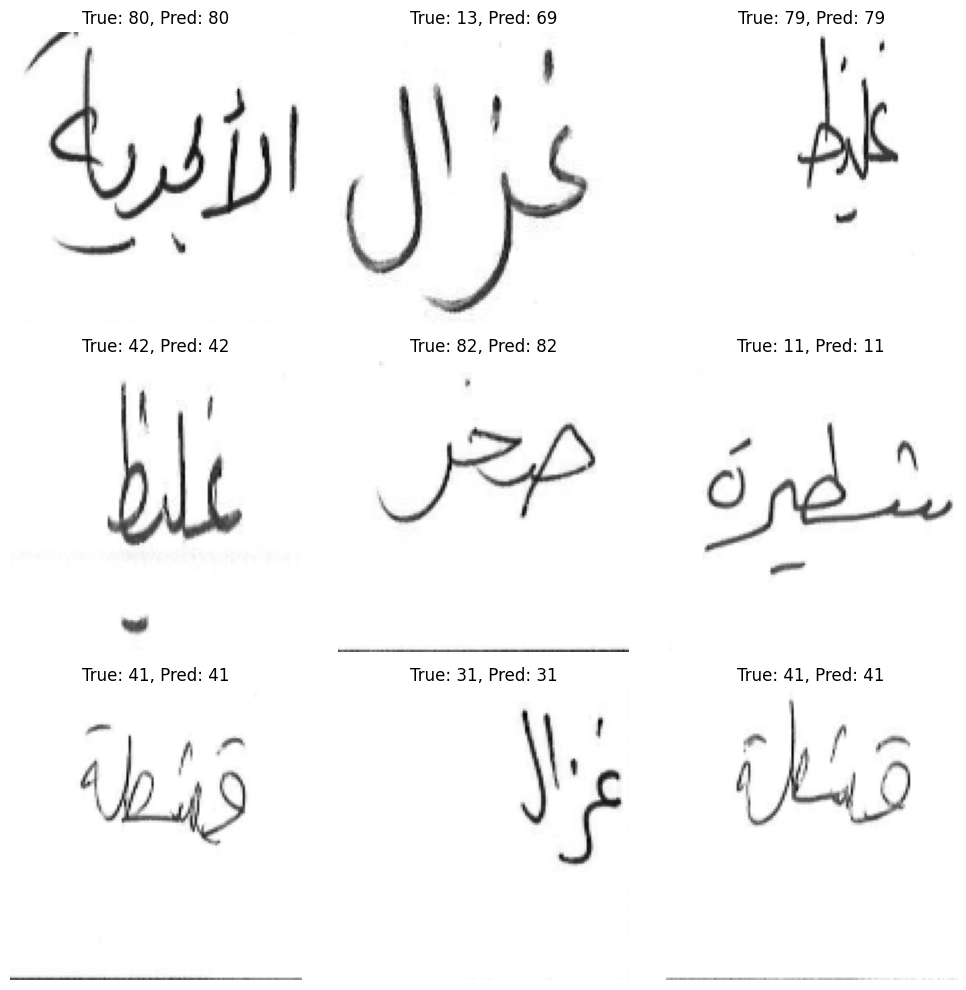

In [ ]:
# Get predictions from model 8
predictions8 = model8.predict(test_images)

# Convert predictions (probabilities) to class labels
predicted_labels8 = np.argmax(predictions8, axis=1)

def plot_predictions(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(10, 10))
    random_indices = random.sample(range(len(images)), num_images)

    for i, idx in enumerate(random_indices):
        image = images[idx].reshape(128, 128)
        true_label = true_labels[idx] + 1  # Convert back to original label range (1 to 82)
        predicted_label = predicted_labels[idx] + 1

        plt.subplot(3, 3, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot predictions for model7
print("Model 8 Predictions:")
plot_predictions(test_images, test_labels, predicted_labels8)


## **Loss vs. Epoch number + Accuracy for each model**

**Merged in one plot**

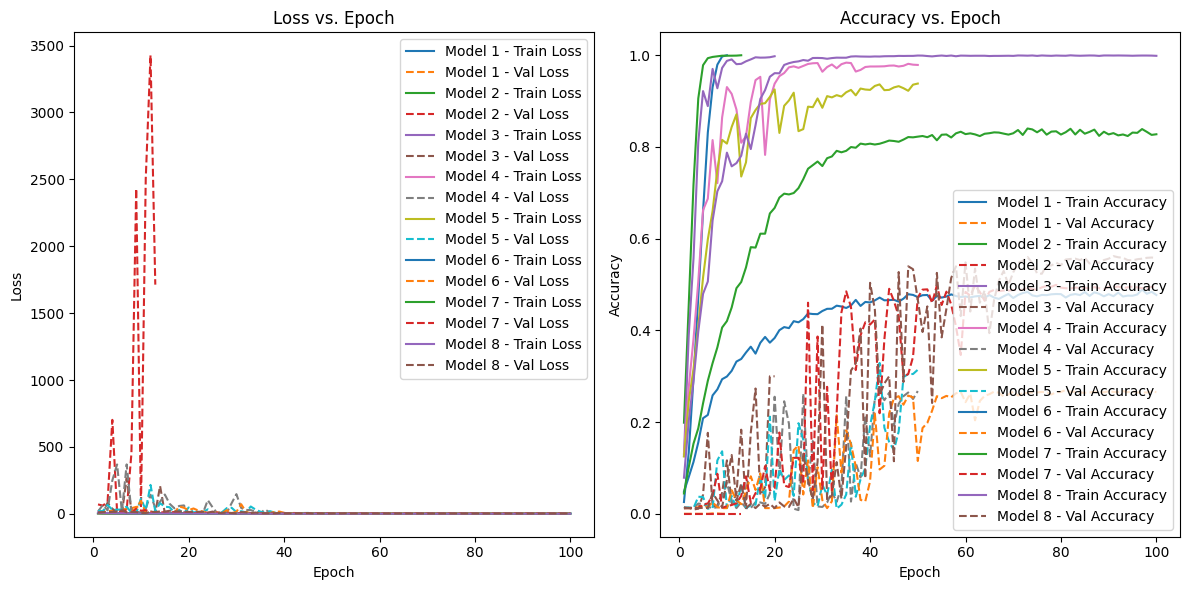

In [ ]:
import matplotlib.pyplot as plt

def plot_multiple_histories(histories, model_labels):
    """
    Plots Loss vs Epoch and Accuracy vs Epoch for multiple models.

    Parameters:
    - histories: List of history objects (from model.fit)
    - model_labels: List of labels for each model
    """
    # Plot Loss vs. Epoch
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        epochs_range = range(1, len(history.history['loss']) + 1)
        plt.plot(epochs_range, history.history['loss'], label=f'{model_labels[i]} - Train Loss')
        plt.plot(epochs_range, history.history['val_loss'], linestyle='dashed', label=f'{model_labels[i]} - Val Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy vs. Epoch
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        epochs_range = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs_range, history.history['accuracy'], label=f'{model_labels[i]} - Train Accuracy')
        plt.plot(epochs_range, history.history['val_accuracy'], linestyle='dashed', label=f'{model_labels[i]} - Val Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
model_histories = [history1, history2,history3, history4, history5, history6, history7, history8]
model_labels = [f'Model {i+1}' for i in range(8)]
plot_multiple_histories(model_histories, model_labels)


**Splitted**

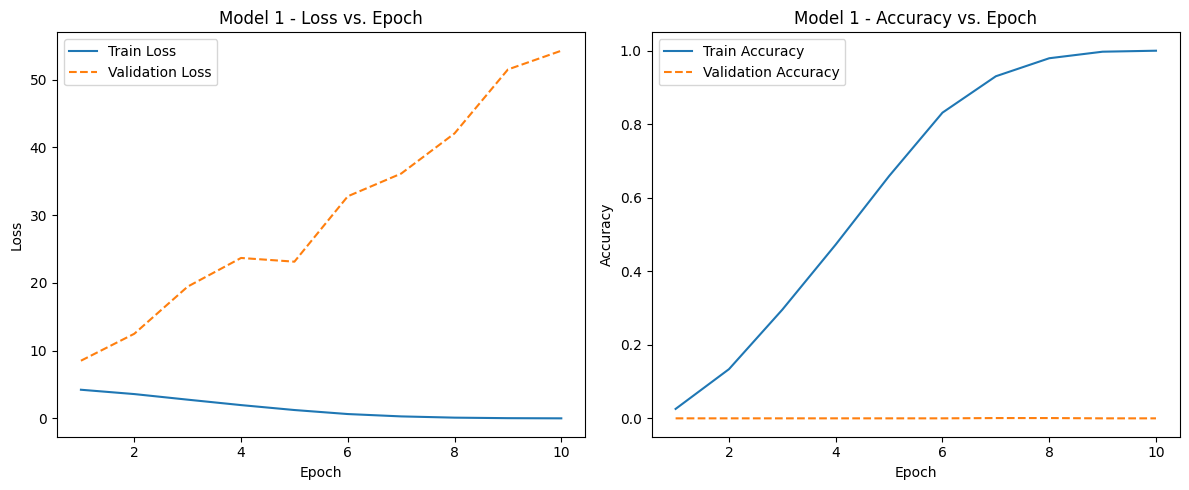

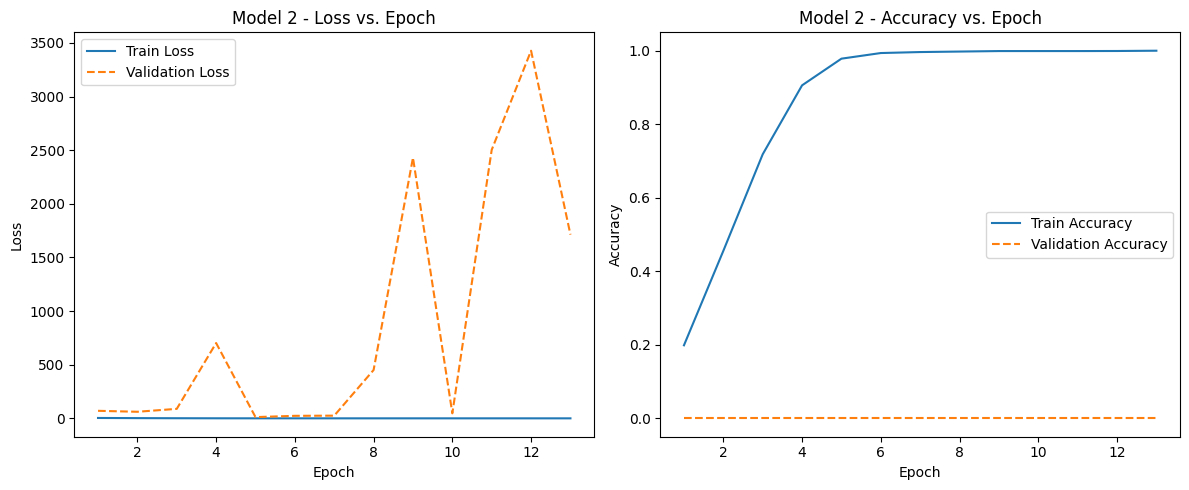

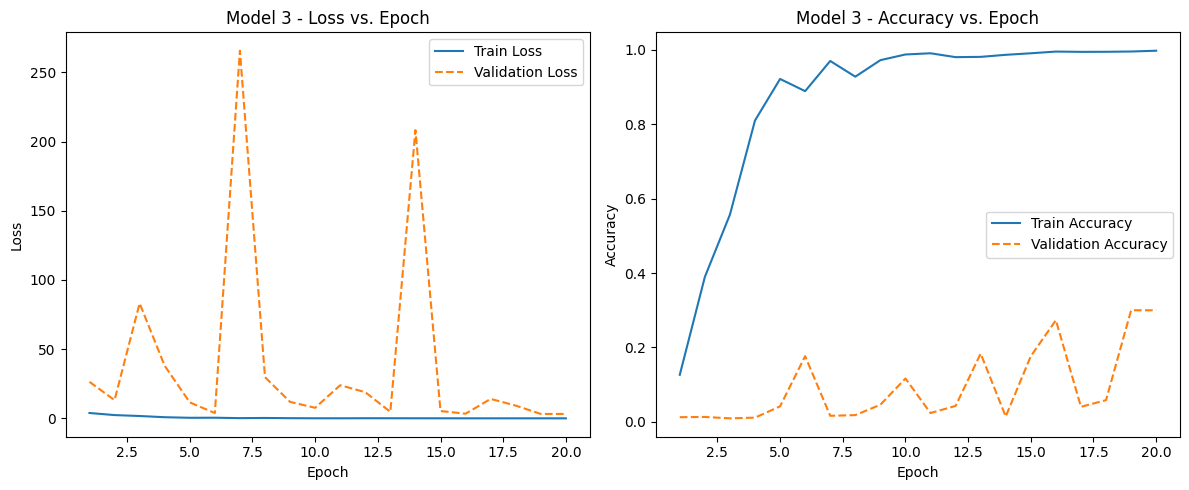

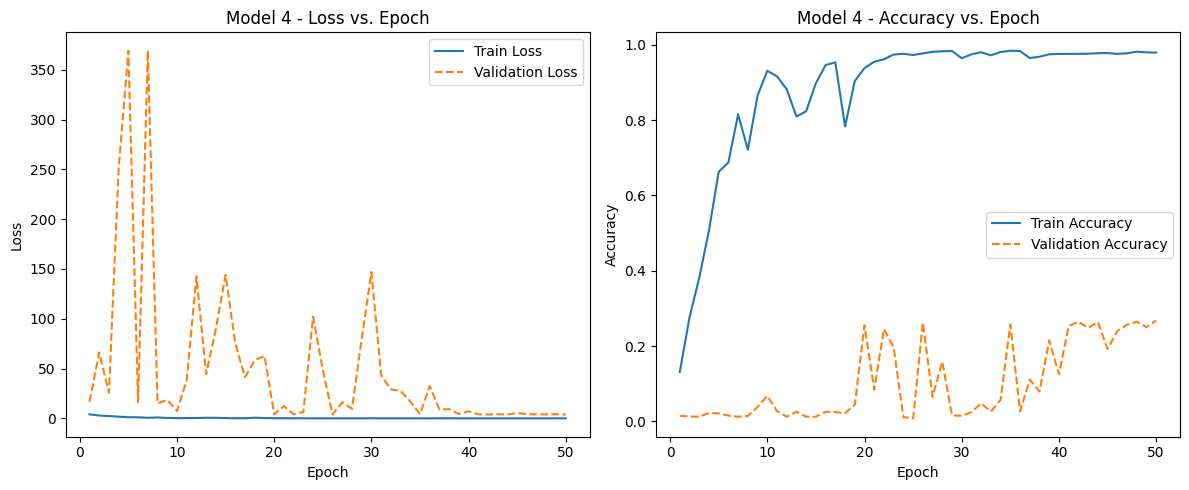

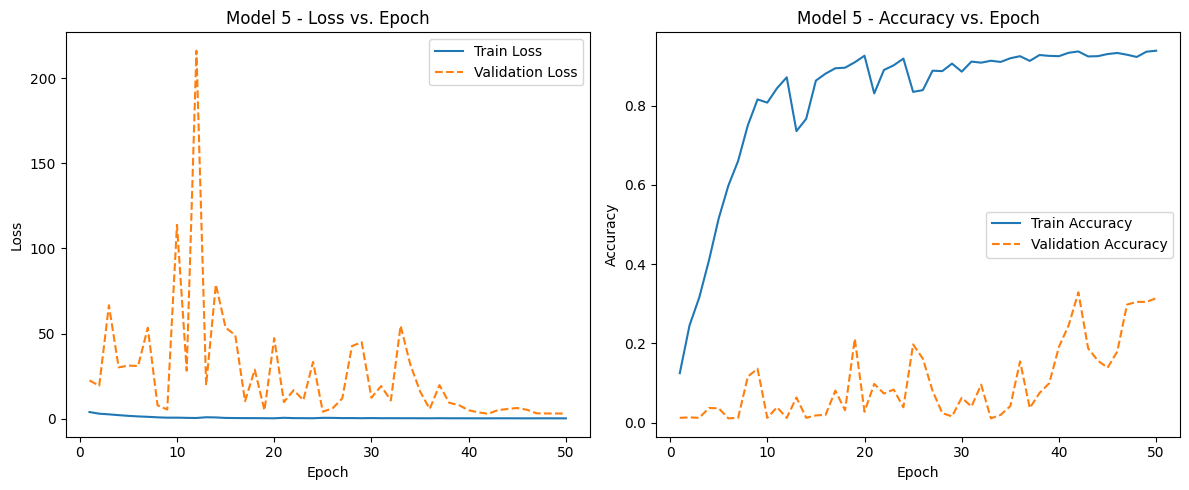

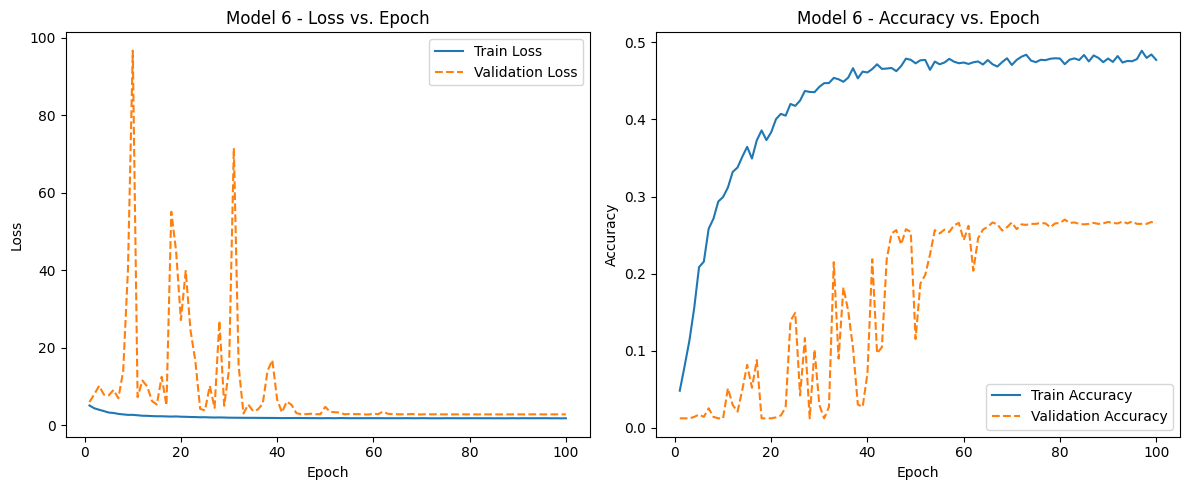

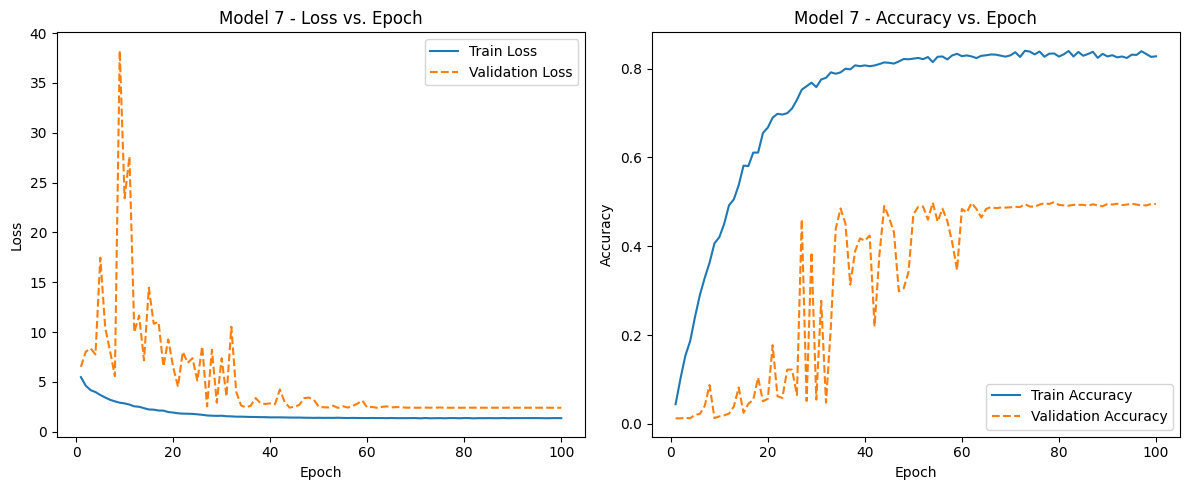

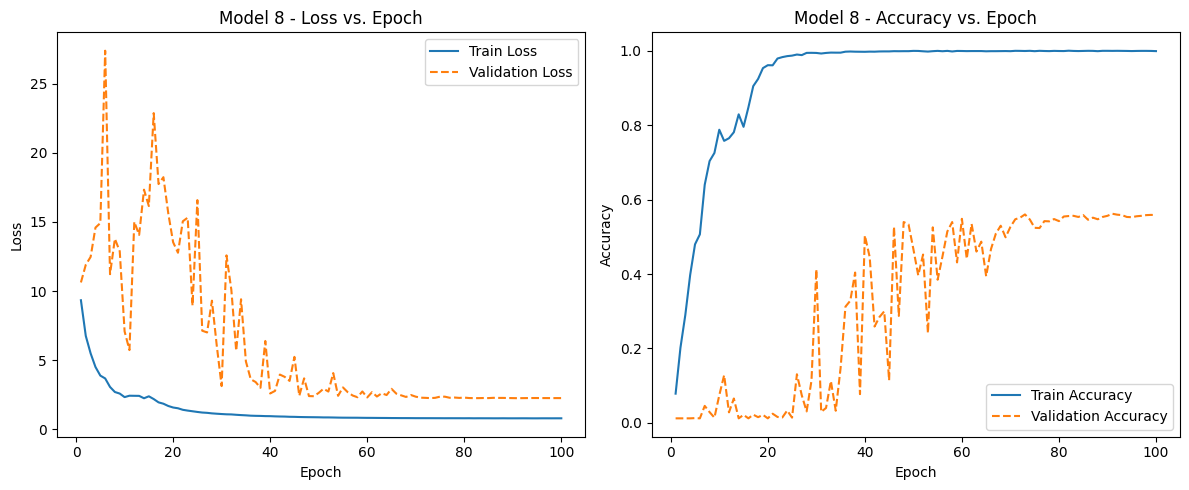

In [ ]:
def plot_single_history(history, model_label):
    """
    Plots Loss vs Epoch and Accuracy vs Epoch for a single model.

    Parameters:
    - history: History object from model.fit
    - model_label: Label for the model (for the plot title)
    """
    epochs_range = range(1, len(history.history['loss']) + 1)

    # Plot Loss vs. Epoch
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss')
    plt.plot(epochs_range, history.history['val_loss'], linestyle='dashed', label='Validation Loss')
    plt.title(f'{model_label} - Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], linestyle='dashed', label='Validation Accuracy')
    plt.title(f'{model_label} - Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
model_histories = [history1, history2, history3, history4, history5, history6, history7, history8]
model_labels = [f'Model {i+1}' for i in range(8)]

# Plot each model individually
for i in range(len(model_histories)):
    plot_single_history(model_histories[i], model_labels[i])


**Saving the histories**

In [ ]:
def save_history(history, filename):
    """
    Saves the training history to a pickle file.

    Parameters:
    - history: History object from model.fit
    - filename: Path in Google Drive where the history will be saved
    """
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"History saved at: {filename}")

# Example usage: Save each history
history_files = [
    "/content/drive/My Drive/Dataset/history1.pkl",
    "/content/drive/My Drive/Dataset/history2.pkl",
    "/content/drive/My Drive/Dataset/history3.pkl",
    "/content/drive/My Drive/Dataset/history4.pkl",
    "/content/drive/My Drive/Dataset/history5.pkl",
    "/content/drive/My Drive/Dataset/history6.pkl",
    "/content/drive/My Drive/Dataset/history7.pkl",
    "/content/drive/My Drive/Dataset/history8.pkl"
]

model_histories = [history1, history2, history3, history4, history5, history6, history7, history8]

# Save each history
for hist, file in zip(model_histories, history_files):
    save_history(hist, file)


History saved at: /content/drive/My Drive/Dataset/history1.pkl
History saved at: /content/drive/My Drive/Dataset/history2.pkl
History saved at: /content/drive/My Drive/Dataset/history3.pkl
History saved at: /content/drive/My Drive/Dataset/history4.pkl
History saved at: /content/drive/My Drive/Dataset/history5.pkl
History saved at: /content/drive/My Drive/Dataset/history6.pkl
History saved at: /content/drive/My Drive/Dataset/history7.pkl
History saved at: /content/drive/My Drive/Dataset/history8.pkl


# Task 2

## **Visualzing some of the augmented images**

**Since our best model was model (8), we are going to retrain it after doing data augmentation and see the results**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=1,          # Slight rotation
    width_shift_range=0.005,   # Small horizontal shifts
    height_shift_range=0.005,  # Small vertical shifts
    zoom_range=0.01,           # Slight zooming in/out
    horizontal_flip=True,      # Horizontal flipping
    fill_mode='nearest'        # Filling pixels by nearest values
)

# Create train generator
train_generator = train_datagen.flow(train_images, train_labels, batch_size=64)

# Model definition
model8_augmented3 = Sequential([
    InputLayer(input_shape=(128, 128, 1)),

    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),

    # Second Convolutional Block
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),

    # Fourth Convolutional Block
    Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.3),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    # Output Layer
    Dense(82, activation='softmax', kernel_regularizer=l2(0.005))
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model8_augmented3.compile(optimizer=optimizer,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Class balancing
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Train the model with data augmentation
history8_augmented3 = model8_augmented3.fit(
    train_generator,
    epochs=100,
    validation_data=(test_images, test_labels),
    class_weight=class_weights,
    callbacks=[lr_scheduler]
)

# Evaluate the model
loss8_augmented3, accuracy8_augmented3 = model8_augmented3.evaluate(test_images, test_labels, verbose=1)
print(f"Model 8 Test Loss: {loss8_augmented3:.4f}, Test Accuracy: {accuracy8_augmented3:.4f}")

# Save the model
model8_augmented3.save('/content/drive/My Drive/Dataset/cnn_model8_augmented3.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - accuracy: 0.0339 - loss: 10.4329 - val_accuracy: 0.0124 - val_loss: 10.4952 - learning_rate: 0.0010
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.1372 - loss: 7.3626 - val_accuracy: 0.0124 - val_loss: 11.6107 - learning_rate: 0.0010
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.1775 - loss: 5.8164 - val_accuracy: 0.0124 - val_loss: 13.4117 - learning_rate: 0.0010
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.2365 - loss: 5.0858 - val_accuracy: 0.0124 - val_loss: 14.9344 - learning_rate: 0.0010
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.2761 - loss: 4.7436 - val_accuracy: 0.0124 - val_loss: 15.8434 - learning_rate: 0.0010
Epoch 6/100
102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3752 - loss: 3.9970
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
103/103 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.3752 

## Model 8, in addition to augmentation

## Loss vs. Epoch number + the model's accuracy

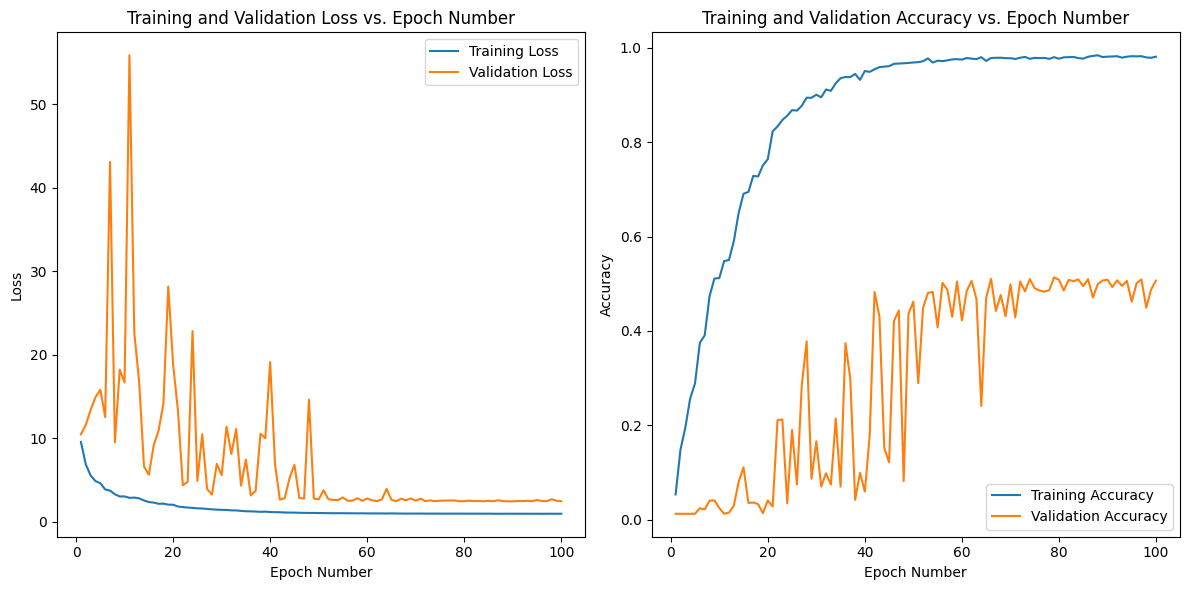

In [ ]:
# Ensure history variable is available
if 'history8_augmented3' in locals():
    epochs = range(1, len(history8_augmented3.history['loss']) + 1)

    # Plot Loss vs. Epochs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history8_augmented3.history['loss'], label='Training Loss')
    plt.plot(epochs, history8_augmented3.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch Number')
    plt.legend()

    # Plot Accuracy vs. Epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history8_augmented3.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history8_augmented3.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy vs. Epoch Number')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Error: No history available. Please run the training or provide the saved history.")


# Task 3

Mounted at /content/drive


100%|██████████| 82/82 [00:27<00:00,  3.01it/s]


Total Images: 4478, Shape: (4478, 128, 128, 1), Unique Labels: 45
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 384ms/step - accuracy: 0.0619 - loss: 3.9200 - val_accuracy: 0.2087 - val_loss: 3.1425 - learning_rate: 5.0000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.2167 - loss: 3.1060 - val_accuracy: 0.3337 - val_loss: 2.7988 - learning_rate: 5.0000e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.3276 - loss: 2.7299 - val_accuracy: 0.4029 - val_loss: 2.6047 - learning_rate: 5.0000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.4062 - loss: 2.4996 - val_accuracy: 0.4520 - val_loss: 2.4129 - learning_rate: 5.0000e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.4653 - loss: 2.3024 - val_accuracy: 0.4688 - val_loss: 2.3433 - learning_rate: 5.0000e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.5139 - loss: 2.1875 - val_accuracy: 0.4766 - val_loss: 2.2736 - learning_rate: 5.0000e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.53

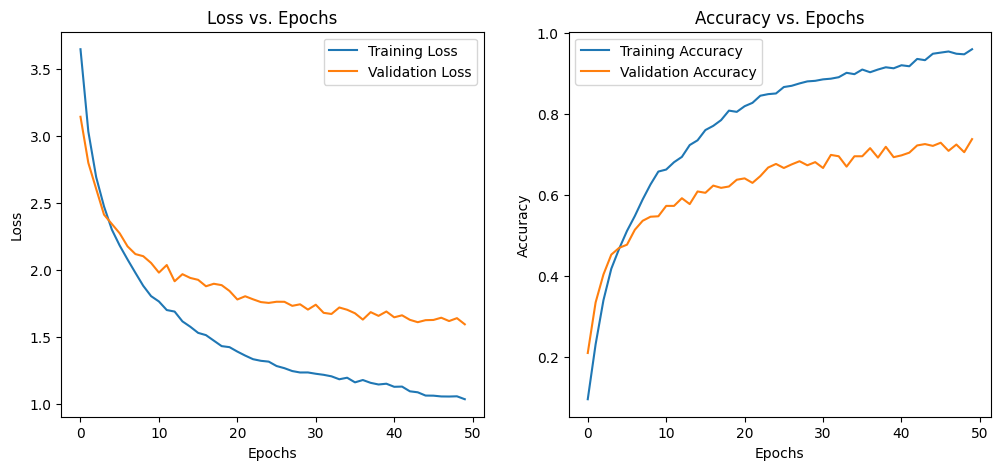

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path to dataset
dataset_folder = '/content/drive/My Drive/Dataset/isolated_words_per_user'

# Load dataset
data = []
for user_folder in tqdm(sorted(os.listdir(dataset_folder))):
    user_path = os.path.join(dataset_folder, user_folder)
    if not os.path.isdir(user_path):
        continue
    label = int(user_folder.replace('user', '')) - 1  # Convert user ID to 0-indexed label
    for image_name in os.listdir(user_path):
        image_path = os.path.join(user_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image_resized = cv2.resize(image, (128, 128))
            image_normalized = image_resized.astype('float32') / 255.0  # Normalize to [0, 1]
            data.append((image_normalized, label))

# Convert to numpy arrays
images, labels = zip(*data)
images = np.array(images).reshape(-1, 128, 128, 1)  # Add channel dimension
labels = np.array(labels)

print(f"Total Images: {len(images)}, Shape: {images.shape}, Unique Labels: {len(np.unique(labels))}")

# Split into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_labels.reshape(-1, 1))

# Convert grayscale to RGB by repeating channels
train_images_rgb = np.repeat(train_images, 3, axis=-1)
test_images_rgb = np.repeat(test_images, 3, axis=-1)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(train_images_rgb, train_labels_one_hot, batch_size=64)

# Load MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model for transfer learning

# Create Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(np.unique(labels)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0005)
loss = CategoricalCrossentropy(label_smoothing=0.1)  # Label smoothing for generalization
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=(test_images_rgb, test_labels_one_hot),
    epochs=50,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images_rgb, test_labels_one_hot, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save the model
model.save('/content/drive/My Drive/Dataset/mobilenetv2_augmented.keras')

# Plot Loss and Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Task 4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 82/82 [00:24<00:00,  3.39it/s]


Total Images: 4478, Shape: (4478, 128, 128, 3), Unique Labels: 45
Training set: (3582, 128, 128, 3), Testing set: (896, 128, 128, 3)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 60s 228ms/step - accuracy: 0.0688 - loss: 3.8023 - val_accuracy: 0.0324 - val_loss: 4.3749 - learning_rate: 5.0000e-04
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.2901 - loss: 2.4253 - val_accuracy: 0.0279 - val_loss: 5.1724 - learning_rate: 5.0000e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - accuracy: 0.4031 - loss: 1.9234 - val_accuracy: 0.0223 - val_loss: 5.4106 - learning_rate: 5.0000e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.5043 - loss: 1.5699 - val_accuracy: 0.0223 - val_loss: 6.2702 - learning_rate: 5.0000e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.5724 - loss: 1.3622 - val_accuracy: 0.0435 - val_loss: 5.0505 - learning_rate: 5.0000e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6370 - loss: 1.1037
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accura

Test Loss: 4.3749, Test Accuracy: 0.0324


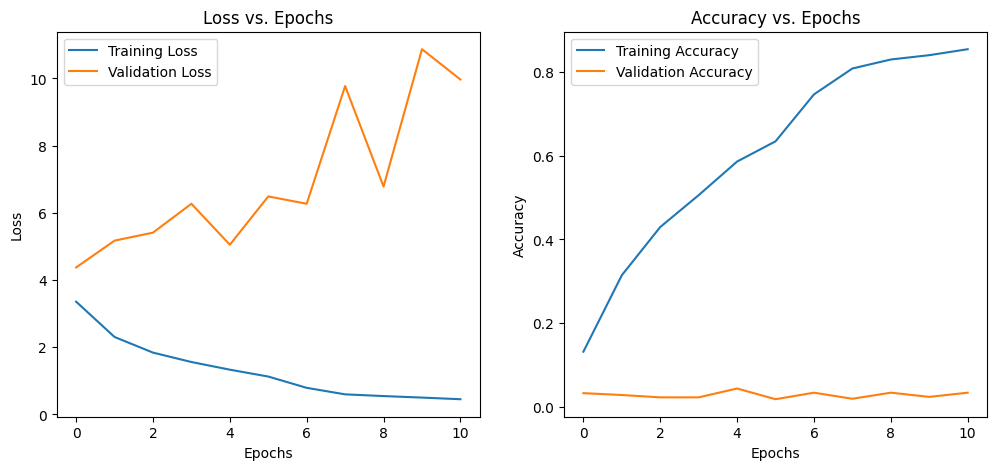

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Reshape, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Dataset Path
dataset_folder = '/content/drive/My Drive/Dataset/isolated_words_per_user'

# Prepare Data
data = []
for user_folder in tqdm(sorted(os.listdir(dataset_folder))):
    user_path = os.path.join(dataset_folder, user_folder)
    if not os.path.isdir(user_path):
        continue
    label = int(user_folder.replace('user', '')) - 1  # Writer ID starts from 0
    for image_name in os.listdir(user_path):
        image_path = os.path.join(user_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is not None:
            image_resized = cv2.resize(image, (128, 128)).astype('float32') / 255.0
            data.append((image_resized, label))

# Convert to numpy arrays
images, labels = zip(*data)
images = np.array(images)
labels = np.array(labels)

print(f"Total Images: {len(images)}, Shape: {images.shape}, Unique Labels: {len(np.unique(labels))}")

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training set: {train_images.shape}, Testing set: {test_images.shape}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

# ** CNN-LSTM Model Implementation **
class CNNLSTMModel:
    def __init__(self, input_shape=(128, 128, 3), num_classes=82):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.build()

    def build_cnn(self, inputs):
        """Build CNN feature extractor using MobileNetV2."""
        base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=self.input_shape)
        cnn_output = base_model(inputs)  # CNN output shape: (4, 4, 1280)
        cnn_output = Flatten()(cnn_output)  # Flatten to (20480,)
        return cnn_output

    def build_lstm(self, cnn_output):
        """Reshape and pass CNN output to LSTM."""
        reshaped_output = Reshape((16, 20480 // 16))(cnn_output)  # Reshape to (16, 1280)
        lstm_output = LSTM(256, return_sequences=True)(reshaped_output)  # LSTM to learn sequences
        lstm_output = TimeDistributed(Dense(128, activation='relu'))(lstm_output)
        lstm_output = Flatten()(lstm_output)
        return lstm_output

    def build(self):
        """Build complete CNN-LSTM model."""
        inputs = Input(shape=self.input_shape)
        cnn_output = self.build_cnn(inputs)
        lstm_output = self.build_lstm(cnn_output)
        lstm_output = Dropout(0.5)(lstm_output)
        outputs = Dense(self.num_classes, activation='softmax')(lstm_output)

        self.model = Model(inputs, outputs)

    def compile_model(self):
        """Compile the model."""
        optimizer = Adam(learning_rate=0.0005)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train_model(self, train_gen, val_data, class_weights):
        """Train the model."""
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

        history = self.model.fit(
            train_gen,
            validation_data=val_data,
            epochs=50,
            class_weight=class_weights,
            callbacks=[early_stopping, lr_scheduler]
        )
        return history

    def evaluate_model(self, test_images, test_labels):
        """Evaluate the model."""
        loss, accuracy = self.model.evaluate(test_images, test_labels, verbose=1)
        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
        return loss, accuracy

    def save_model(self, path):
        """Save the trained model."""
        self.model.save(path)


# ** Create and Train the Model **
cnn_lstm_model = CNNLSTMModel(input_shape=(128, 128, 3), num_classes=82)
cnn_lstm_model.compile_model()

history = cnn_lstm_model.train_model(
    train_generator,
    val_data=(test_images, test_labels),
    class_weights=class_weights
)

# Evaluate the model
cnn_lstm_model.evaluate_model(test_images, test_labels)

# Save the model
cnn_lstm_model.save_model('/content/drive/My Drive/Dataset/arabic_writer_cnn_lstm.h5')

# Plot Loss vs. Epoch Number and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()
